In [24]:
import torch
import torchvision

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim

from torchessian import spectrum
from torchvision.models import resnet18

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

m = 100

Files already downloaded and verified
Files already downloaded and verified


In [21]:
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(512, 10)

for p in net.conv1.parameters():
    p.requires_grad = False

for p in net.bn1.parameters():
    p.requires_grad = False

for p in net.layer1.parameters():
    p.requires_grad = False

net = net.cuda() if torch.cuda.is_available() else net

In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)

In [ ]:
s, d = [], []
for epoch in range(30):  # loop over the dataset multiple times    

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('\n[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / i), "\n")
    running_loss = 0.0
    
    support, density = spectrum(net, criterion, (inputs, labels), m, buffer=m//2)
    s.append(support)
    d.append(density)

In [ ]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

tensor([-803.9973,  804.4182,  463.3869,  455.5653,  444.6622,  423.1543,
        -462.7428, -458.2914, -447.4030, -418.0604, -409.1657,  402.1902,
         397.2088, -401.4518, -378.6168, -384.3834, -360.6557,  381.3625,
         374.3243,  364.3257,  347.8559, -347.2759, -337.3768, -320.9865,
         338.0079,  340.2752,  331.1695, -324.1258, -307.9989,  305.2120,
         299.7822, -293.1870, -290.2128, -277.6223,  292.6011,  276.9612,
        -266.8000, -264.1069, -257.5330,  268.1128,  264.3424,  261.3851,
         252.7653,  250.8058,  245.6714, -250.4844, -224.5648, -230.4616,
        -243.1855, -236.1363,  237.2608, -246.8527, -201.3837, -208.5332,
        -194.1492, -182.5968,  229.0325,  223.1205, -175.8397,   91.0450,
        -155.5013, -147.9676,  213.3057,   80.2989,   96.9464,  121.9840,
          65.5051,   55.5092,  132.7887, -135.2727,  -67.1175,  -74.7591,
          43.2726,  137.8848,  -60.0262,  193.5951, -124.2009,  -92.1755,
         -46.7759,  150.4177,   -2.312

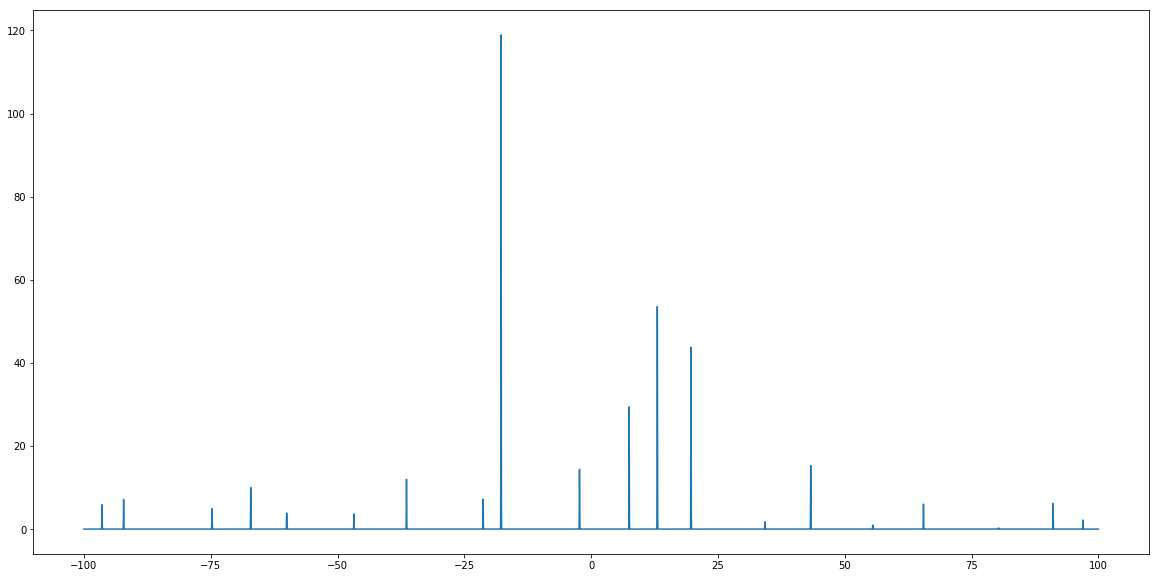

In [7]:
support, density = spectrum(model, loss_function, batch, 100) 
plt.figure(figsize=(20,10))
plt.plot(support.numpy(), density.numpy())
plt.show()

In [21]:
model = torch.nn.Linear(2, 1)
torch.manual_seed(2019)
v = torch.Tensor([1, 2, 3])
x = torch.rand(10, 2)
y = x.sum(1)
m = 2
def loss_function(y_hat, y):
    return ((y_hat.view(-1) - y.view(-1)) * (y_hat.view(-1) - y.view(-1))).sum() / y.numel()
batch = x, y

tensor([2.9951, 0.0557])
tensor([2.9952, 0.0415, 0.1725])


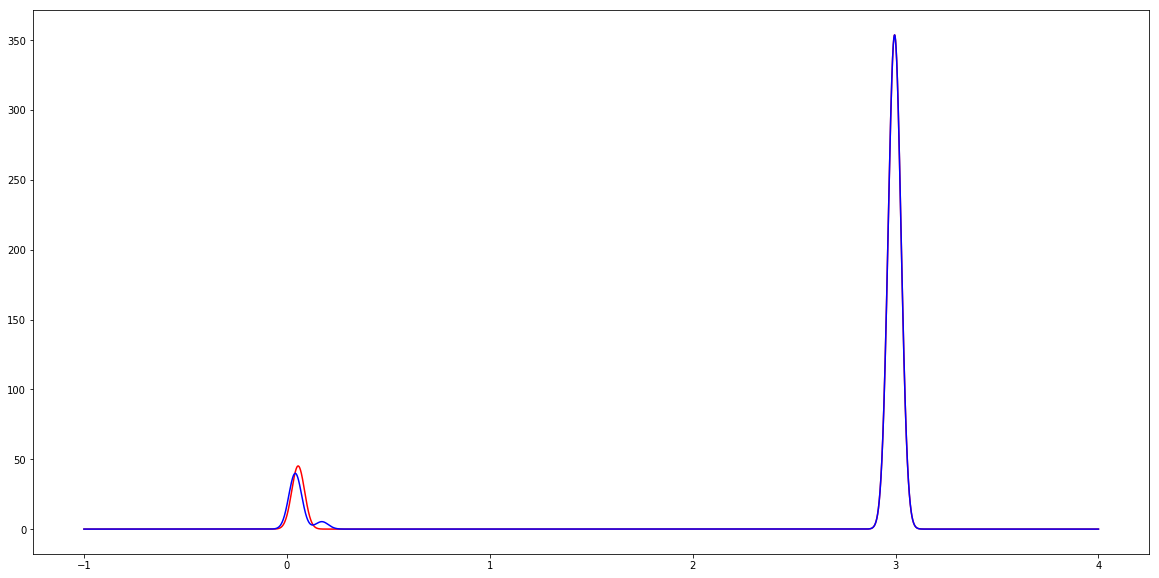

In [23]:
plt.figure(figsize=(20,10))
support, density = spectrum(model, loss_function, batch, 2, -1, 4)
plt.plot(support.numpy(), density.numpy(), color='r')
support, density = spectrum(model, loss_function, batch, 3, -1, 4)
plt.plot(support.numpy(), density.numpy(), color='b')
plt.show()